In [4]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("data/iris.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:

y = pd.DataFrame()
X = df[["sepal_length", "sepal_width"]].to_numpy()
y['variety'] = df["variety"].apply(lambda x: int(x == "Iris-setosa") - int(x != "Iris-setosa"))
y = y[['variety']].to_numpy()

In [7]:
class GradientDescent:
    def __init__(self, train_x, train_y, h = 0.00005, eps=0.1, start_weights=None, logging=False, min_iterations=0, strategy="package", batch_size=1, lambda_=0): #Добавил параметр лямбда для регуляризации

        #часть за данные ааа
        self.X = train_x #тренировочная выборка
        self.y = train_y #целевой признак
        self.strategy = strategy

        #метаданные
        self.width = len(train_x[0]) + 1 #ширина тренировочной выборки
        self.height = len(train_x) #высота тренировочной выборки
        
        #модель 
        self.batch_size = batch_size
        self.min_iterations = min_iterations
        self.h = h #шаг градиентного спуска h > 0
        self.lambda_ = lambda_ #коэффициент регуляризации
        self.eps = eps #точность градиентного спуска
        self.strategies = {'package': self.step_package, 'mini-batch': self.step_mini_batch, 'stochastic': self.step_mini_batch}
        if strategy == 'stochastic':
            self.batch_size = 1
        if start_weights is None: #задание стартовых весов
            self.w = np.full(self.width, 1)
        else:
            self.w = start_weights

        self.X = np.concatenate((np.ones(self.height).reshape(-1, 1), self.X), axis=1) #фиктивная единица
        self.q = self.calc_q() # инициализируем ошибку

        #логи
        self.logging = logging
        self.qs = np.array([]) #величина ошибки
        self.curr_timer = None
        self.timer = np.array([]) #массив для хранения время итераций
        self.iter_num = 0
        
        
    def start_timer(self):
        self.curr_timer = datetime.datetime.now()
    
    def stop_timer(self):
        self.timer = np.append(self.timer, np.array(datetime.datetime.now() - self.curr_timer))

    def get_time(self):
        return self.timer.sum()

    def get_times(self):
        return self.timer
    
    def step_package(self):
        self.start_timer()
        self.w = self.w - self.h * self.grad()

    
    def step_mini_batch(self):
        
        idx = np.random.randint(self.height, size=self.batch_size) # формируем индексы пакета
        self.w = self.w - self.h * self.grad(self.X[idx, :], self.y[idx, :]) #вычисляем градиент по пакету и меняем веса
        
    
    def grad(self, X = None, y = None): #вычисление градиента по пакету(подходит для mini-batch, package и stochastic)
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y

        return (X.T.dot(X.dot(self.w) - y[:, 0]))*(2/self.height)

    def fit(self):
        
        q = 2*self.q

        if self.logging:
            print("Величина ошибки на каждом шаге")

        while abs(self.q - q) > self.eps or self.iter_num < self.min_iterations:
            self.start_timer()
            q = self.q #переприсваеваем значение ошибки 
            self.strategies[self.strategy]()
            self.qs = np.append(self.qs, q) #запоминаем значение ошибки
            self.q = self.calc_q() #вычисление значение ошибки после новых весов
            self.iter_num += 1
            self.stop_timer()

            if self.logging:
                print(f"Шаг {self.iter_num}: ошибка {round(self.q, int(np.log(1/self.eps)/np.log(10)))};") #логи        
        if self.logging:
            print(f"Время работы: {self.get_time().microseconds/1000:.02f} мс")
        return self.w


    def calc_q(self):
        
        return np.mean((np.dot(self.X, self.w) - self.y[:, 0]) ** 2)

    def predict(self, X):
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.dot(X, self.w).reshape(-1, 1)
    
    

In [34]:

class SupportVectorMachine(GradientDescent):#наследуемся от градиентного спуска
    
    def grad(self, X = None, y = None): #переопределяем вычисление градиента для нового класса svm
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y
        grad = np.zeros(self.width)
        for i in range(len(y)):
            if 1 - y[i]*np.dot(self.w, X[i, :]) > 0:
                grad += -y[i] * X[i, :]
                
        return 2*self.lambda_*self.w + grad #пока написал корявый градиент пускай хотя бы так считает
    
    
    def calc_q(self): #переопределяем функцию ошибки
        loss_result = self.lambda_*((self.w**2).sum())
        for i in range(self.height):
            loss_result += max(0, 1 - self.y[i]*np.dot(self.w, self.X[i, :]))
        return loss_result[0]
    
    def predict(self, X): #переопределяем функцию предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.sign(np.dot(X, self.w).reshape(-1, 1))



In [64]:
class Counter:
    def __init__(self, X_train, X_test, y_train, y_test, model):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred_train = model.predict(self.X_train)
        self.y_pred_test = model.predict(self.X_test)
        self.model = model
    def plot_confusion_matrix(self, y, y_pred, label):
        cm = confusion_matrix(y, y_pred)
        print('Матрица ошибок, полученная методом confusion_matrix\n', cm)
        
        ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='jet')
        
        plt.title(f'Матрица ошибок для {label}')
        plt.show()
    
    def calc_metrics(self, y, y_pred):
        acc = accuracy_score(y, y_pred)
        pre = precision_score(y, y_pred)
        rec = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        print(f"accuracy: {acc}")
        print(f"precision: {pre}")
        print(f"recall: {rec}")
        print(f"f1: {f1}")
        

    def try_model(self):
        self.y_pred_train = self.model.predict(self.X_train)
        self.y_pred_test = self.model.predict(self.X_test)
        print("Метрики для тренировочной выборки")
        self.calc_metrics(self.y_train, self.y_pred_train)
        print()
        print('Метрики для тестовой выборки')
        self.calc_metrics(self.y_test, self.y_pred_test)
        self.plot_confusion_matrix(self.y_train, self.y_pred_train, 'тренировочной выборки')
        self.plot_confusion_matrix(self.y_test, self.y_pred_test, 'тестовой')

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)


In [67]:
svm = SupportVectorMachine(X_train,y_train, logging=True, min_iterations=1000) #специально переобучились)
svm.fit()

Величина ошибки на каждом шаге
Шаг 1: ошибка 878.7;
Шаг 2: ошибка 863.0;
Шаг 3: ошибка 847.3;
Шаг 4: ошибка 831.6;
Шаг 5: ошибка 815.9;
Шаг 6: ошибка 800.3;
Шаг 7: ошибка 784.6;
Шаг 8: ошибка 768.9;
Шаг 9: ошибка 753.2;
Шаг 10: ошибка 737.5;
Шаг 11: ошибка 721.8;
Шаг 12: ошибка 706.1;
Шаг 13: ошибка 690.4;
Шаг 14: ошибка 674.7;
Шаг 15: ошибка 659.0;
Шаг 16: ошибка 643.3;
Шаг 17: ошибка 627.6;
Шаг 18: ошибка 612.0;
Шаг 19: ошибка 596.3;
Шаг 20: ошибка 580.6;
Шаг 21: ошибка 564.9;
Шаг 22: ошибка 549.2;
Шаг 23: ошибка 533.5;
Шаг 24: ошибка 517.8;
Шаг 25: ошибка 502.1;
Шаг 26: ошибка 486.4;
Шаг 27: ошибка 470.7;
Шаг 28: ошибка 455.0;
Шаг 29: ошибка 439.3;
Шаг 30: ошибка 423.7;
Шаг 31: ошибка 408.0;
Шаг 32: ошибка 392.3;
Шаг 33: ошибка 376.6;
Шаг 34: ошибка 360.9;
Шаг 35: ошибка 345.2;
Шаг 36: ошибка 329.5;
Шаг 37: ошибка 313.8;
Шаг 38: ошибка 298.1;
Шаг 39: ошибка 282.4;
Шаг 40: ошибка 266.7;
Шаг 41: ошибка 251.1;
Шаг 42: ошибка 235.4;
Шаг 43: ошибка 219.7;
Шаг 44: ошибка 204.0;
Шаг 45: ош

array([ 0.90575 , -1.05015 ,  1.527985])

In [68]:
cntr = Counter(X_train, X_test, y_train, y_test, svm)


Метрики для тренировочной выборки
accuracy: 0.9916666666666667
precision: 1.0
recall: 0.975
f1: 0.9873417721518988

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[80  0]
 [ 1 39]]


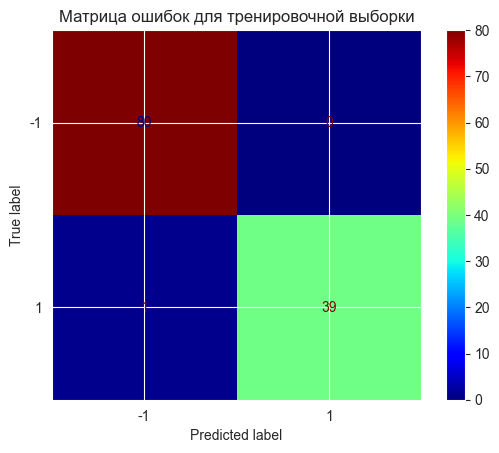

Матрица ошибок, полученная методом confusion_matrix
 [[20  0]
 [ 0 10]]


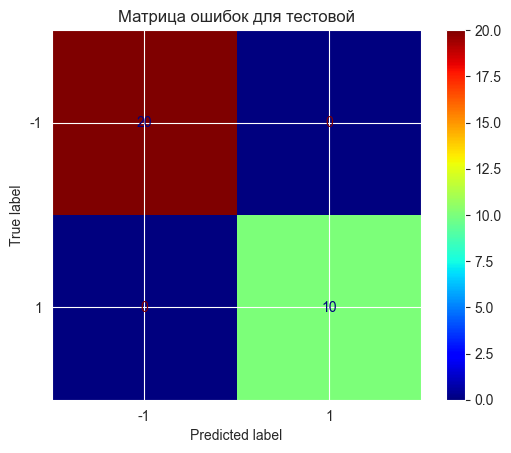

In [69]:
cntr.try_model()

In [70]:
svm_mini_batch = SupportVectorMachine(X_train, y_train, logging=True, h=0.0005, min_iterations=1000, strategy='mini-batch') 
svm_mini_batch.fit()

Величина ошибки на каждом шаге
Шаг 1: ошибка 894.4;
Шаг 2: ошибка 894.4;
Шаг 3: ошибка 892.7;
Шаг 4: ошибка 890.7;
Шаг 5: ошибка 888.6;
Шаг 6: ошибка 886.5;
Шаг 7: ошибка 884.5;
Шаг 8: ошибка 882.3;
Шаг 9: ошибка 880.5;
Шаг 10: ошибка 878.4;
Шаг 11: ошибка 878.4;
Шаг 12: ошибка 876.4;
Шаг 13: ошибка 874.7;
Шаг 14: ошибка 873.2;
Шаг 15: ошибка 871.3;
Шаг 16: ошибка 869.2;
Шаг 17: ошибка 867.0;
Шаг 18: ошибка 864.9;
Шаг 19: ошибка 863.1;
Шаг 20: ошибка 861.0;
Шаг 21: ошибка 858.9;
Шаг 22: ошибка 858.9;
Шаг 23: ошибка 857.2;
Шаг 24: ошибка 854.9;
Шаг 25: ошибка 854.9;
Шаг 26: ошибка 852.4;
Шаг 27: ошибка 850.3;
Шаг 28: ошибка 850.3;
Шаг 29: ошибка 850.3;
Шаг 30: ошибка 850.3;
Шаг 31: ошибка 850.3;
Шаг 32: ошибка 850.3;
Шаг 33: ошибка 850.3;
Шаг 34: ошибка 848.1;
Шаг 35: ошибка 846.2;
Шаг 36: ошибка 844.3;
Шаг 37: ошибка 842.2;
Шаг 38: ошибка 840.4;
Шаг 39: ошибка 840.4;
Шаг 40: ошибка 838.4;
Шаг 41: ошибка 838.4;
Шаг 42: ошибка 838.4;
Шаг 43: ошибка 836.4;
Шаг 44: ошибка 836.4;
Шаг 45: ош

array([ 0.7785 , -0.4828 ,  0.41235])

Метрики для тренировочной выборки
accuracy: 0.675
precision: 1.0
recall: 0.025
f1: 0.04878048780487805

Метрики для тестовой выборки
accuracy: 0.6666666666666666
precision: 0.0
recall: 0.0
f1: 0.0
Матрица ошибок, полученная методом confusion_matrix
 [[80  0]
 [39  1]]


C:\Users\Andrey\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


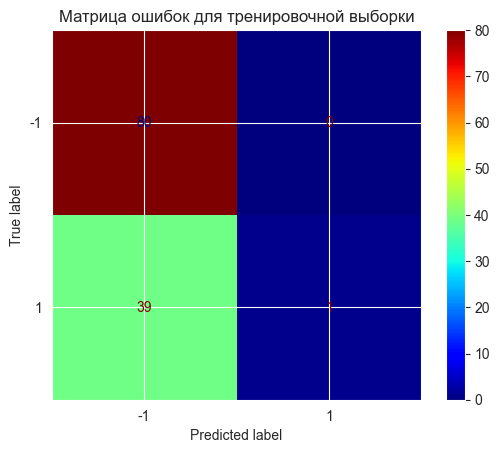

Матрица ошибок, полученная методом confusion_matrix
 [[20  0]
 [10  0]]


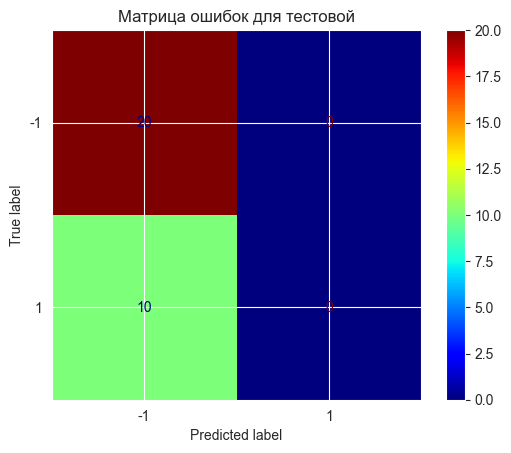

In [71]:
cnt = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cnt.try_model()